# Figure 4
Assuming operation on google colab

In [1]:
# prepare environment
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# prepare environment
!pip install pycombat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# prepare environment
base_dir = "/content/drive/{YOUR PATH}"

import os
os.chdir(base_dir)

In [4]:
import os
import glob
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

from src import difference as diff

In [27]:
# for Figure 4
def main(condition:list=[], n_iter:int=30):
    """ prep data for figure 4 """
    # load data
    ## grp_large as ground truth, large batch, small after BC-qn but before response, small batch
    ## narrow intersection of them
    a = pd.read_pickle(base_dir + "/output/Fig3/grp_f3_A_15.pkl")
    ea = pd.read_pickle(base_dir + "/data/HTHGU133AEA_done_qn.pkl")
    a = a.replace([np.inf,-np.inf],np.nan)
    ea = ea.replace([np.inf,-np.inf],np.nan)
    a = a.dropna()
    ea = ea.dropna()
    batch_a = pd.read_csv(base_dir + "/data/batch_HT-HG-U133A_selected.txt", sep="\t", index_col=0)
    batch_ea = pd.read_csv(base_dir + "/data/batch_HT-HG-U133A_EA_selected.txt", sep="\t", index_col=0)
    comp_a = set(batch_a["cmap_name"])
    comp_ea = set(batch_ea["cmap_name"])
    ixn = comp_a & comp_ea
    batch_a = batch_a[batch_a["cmap_name"].isin(ixn)]
    batch_ea = batch_ea[batch_ea["cmap_name"].isin(ixn)]
    ea = ea.loc[:, list(batch_ea.index)]
    col_a = [v for v in list(a.columns) if v in list(batch_a["cmap_name"])]
    a = a.loc[:, col_a]

    control = list(batch_ea[batch_ea["cmap_name"]=="DMSO"].index)
    treated = list(batch_ea[batch_ea["cmap_name"]!="DMSO"].index)
    print("> #control: ", len(control))
    ixn.remove("DMSO")

    # loop
    out_res = base_dir + "/output/Fig4/response"
    out_corr = base_dir + "/output/Fig4/corr"
    for i in tqdm(range(n_iter)):
        # sample control
        tmp_con = control.copy()
        np.random.shuffle(tmp_con)
        res = []
        for c in condition:
            name = f"0{c}" if c < 10 else str(c)
            # reconstruct batch
            re_idx = treated + tmp_con[:c]
            re_batch = batch_ea.loc[re_idx, :]
            # calculate response, save them
            tmp_ea = diff.to_response(
                    'madz', ea, re_batch, key_compound='cmap_name',
                    vehicle_control=True, control_names=['DMSO','medium'],
                    drop_control=True, intra_batch=False, key_batch='batch_id',
                    spearman=False, out_dir=out_res, name=f"n{name}_iter{i}"
            )
            # calculate interDC
            ixn2 = list(set(a.columns) & set(tmp_ea.columns))
            tmp_a = a.copy()
            tmp_a = tmp_a[ixn2]
            tmp_a.columns = [f"A_{v}" for v in tmp_a.columns]
            tmp_ea.columns = [f"EA_{v}" for v in tmp_ea.columns]
            tmp_df = pd.concat([tmp_a, tmp_ea], join="inner", axis=1)
            res_corr = []
            for t in ixn2:
                tmp_val = tmp_df.loc[:, [f"A_{t}", f"EA_{t}"]]
                corr = tmp_val.corr().values
                res_corr.append(corr[0, 1])              
            res_corr = pd.DataFrame(res_corr, index=ixn2, columns=[f"n{name}"])
            res.append(res_corr)
        res = pd.concat(res, axis=1, join="inner")
        res = res.sort_index()
        res.to_csv(out_corr + f"/iter{i}.csv")


def plot_each():
    """ plot each compound """
    files = glob.glob(base_dir + "/output/Fig4/corr/*.csv")
    names = [f.split("/")[-1].replace(".csv", "") for f in files]
    df = []
    for n, f in zip(names, files):
        tmp = pd.read_csv(f, index_col=0)
        tmp.loc[:, "compound"] = tmp.index
        tmp.loc[:, "iter"] = n
        tmp = tmp.reset_index(drop=True)
        df.append(tmp)
    df = pd.concat(df, axis=0, join="inner")
    df = df.reset_index(drop=True)
    compound = list(set(list(df["compound"])))
    for c in compound:
        # data prep
        tmp = df[df["compound"]==c].copy()
        del tmp["compound"]
        del tmp["iter"]
        x = [""]
        x = x + [int(v.replace("n", "")) for v in tmp.columns]
        tmp_val = [v for v in tmp.values.T]
        # plot
        fig = plt.figure(figsize=(4.5, 4))
        ax = fig.add_subplot(1, 1, 1)
        plt.rcParams["font.size"] = 16
        ax.set_title(c)
        ax.set_xlabel("#control")
        ax.set_ylabel("score")
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.boxplot(
            tmp_val,
            vert=True,
            patch_artist=True,
            boxprops=dict(facecolor='navy',  
                         color='black', linewidth=1, alpha=0.6),  
            medianprops=dict(color='black', linewidth=1),  
            whiskerprops=dict(color='black', linewidth=1),  
            capprops=dict(color='black', linewidth=1),  
            flierprops=dict(markeredgecolor='black', markeredgewidth=1)            
        )
        plt.xticks(list(range(tmp.shape[1] + 1)), x)
        plt.tight_layout()
        plt.savefig(base_dir + f"/output/Fig4/each/{c}.png", bbox_inches='tight')
    df = df.reset_index(drop=True)
    df.to_csv(base_dir + "/output/Fig4/summary.csv")


def plot_heatmap():
    """ plot a heatmap of results including all compounds """
    # data prep
    data = pd.read_csv(base_dir + "/output/Fig4/summary.csv", index_col=0)
    del data["iter"]
    data = data.groupby("compound").mean()
    data = data.sort_values("n12", ascending=False)
    data.to_csv(base_dir + f"/output/Fig4/corr_mean.csv")
    print(data.head())

    # visualize
    fig = plt.figure(figsize=(7, 7))
    plt.rcParams["font.size"] = 16
    ax = fig.add_subplot(1, 1, 1)
    sns.heatmap(data, square=True, cmap="cividis", vmax=1.0, vmin=0.0)
    plt.tight_layout()
    plt.savefig(base_dir + f"/output/Fig4/heatmap.png", bbox_inches='tight')
    plt.show()


def check_rep(condition:list=[], n_iter:int=30):
    """ prep data for figure 5 """
    # load data
    ## grp_large as ground truth, large batch, small after BC-qn but before response, small batch
    ## narrow intersection of them
    a = pd.read_pickle(base_dir + "/output/Fig3/grp_f3_A_15.pkl")
    ea = pd.read_pickle(base_dir + "/data/HTHGU133AEA_done_qn.pkl")
    a = a.replace([np.inf,-np.inf],np.nan)
    ea = ea.replace([np.inf,-np.inf],np.nan)
    a = a.dropna()
    ea = ea.dropna()
    batch_a = pd.read_csv(base_dir + "/data/batch_HT-HG-U133A_selected.txt", sep="\t", index_col=0)
    batch_ea = pd.read_csv(base_dir + "/data/batch_HT-HG-U133A_EA_selected.txt", sep="\t", index_col=0)
    comp_a = set(batch_a["cmap_name"])
    comp_ea = set(batch_ea["cmap_name"])
    ixn = comp_a & comp_ea
    ixn = sorted(list(ixn))
    batch_a = batch_a[batch_a["cmap_name"].isin(ixn)]
    batch_ea = batch_ea[batch_ea["cmap_name"].isin(ixn)]
    ea = ea.loc[:, list(batch_ea.index)]
    col_a = [v for v in list(a.columns) if v in list(batch_a["cmap_name"])]
    a = a.loc[:, col_a]
    ixn.remove("DMSO")
    # prep compound list
    idx_ea = dict()
    n_comp = []
    for i in ixn:
        tmp = batch_ea[batch_ea["cmap_name"]==i]
        idx_ea[i] = list(tmp.index)
        n_comp.append(tmp.shape[0])
    n_comp = pd.DataFrame(n_comp, index=ixn, columns=["#replicates"])
    n_comp.to_csv(base_dir + "/output/Fig4/n_replicates.csv")

                                n03       n04       n05       n06       n07  \
compound                                                                      
trichostatin A             0.154334  0.402516  0.423292  0.647738  0.644405   
vorinostat                 0.147263  0.393218  0.407618  0.636985  0.632251   
geldanamycin               0.069971  0.269057  0.277941  0.413353  0.409588   
15-delta prostaglandin J2  0.078752  0.261108  0.269779  0.412589  0.412897   
tanespimycin               0.067883  0.227048  0.237583  0.377040  0.373270   

                                n08       n09       n10       n11       n12  
compound                                                                     
trichostatin A             0.731414  0.728913  0.768132  0.769739  0.791760  
vorinostat                 0.716828  0.713960  0.753221  0.754587  0.776920  
geldanamycin               0.470430  0.471387  0.500315  0.501500  0.517924  
15-delta prostaglandin J2  0.469847  0.469495  0.498631 

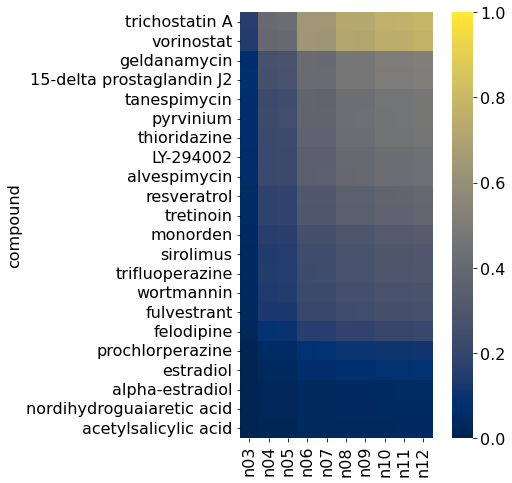

In [26]:
# prepare a heatmap to visualize the results at once
plot_heatmap()

In [ ]:
main(list(range(3, 13, 1)), 50)

> #control:  36


  0%|          | 0/50 [00:00<?, ?it/s]

ストリーミング出力は最後の 5000 行に切り捨てられました。
5202764005790181113004.B11
5202764005790181113004.A12
5202764005791175120104.H07
5202764005791175120104.G08
5202764005791175120104.E09
5202764005791175120104.D10
5202764005791175120104.B11
5202764005791175120104.A12
5202764005789148112904.H01
5202764005789148112904.G02
5202764005789148112904.B05
5202764005789148112904.A06
5202764005789148112904.E03
5202764005789148112904.A12
5202764005789148112904.B11
5202764005789148112904.D10
5202764005789148112904.G08
5202764005789148112904.H07
5202764005789148112904.E09
the following 32 samples were not found in the batch and excluded:
5202764005791175120104.A06
5202764005791175120104.B05
5202764005791175120104.E03
5202764005791175120104.G02
5202764005791175120104.H01
5202764005790181113004.H01
5202764005790181113004.A06
5202764005790181113004.B05
5202764005790181113004.D04
5202764005790181113004.E03
5202764005790181113004.G02
5202764005790181113004.H07
5202764005790181113004.G08
5202764005790181113004.E09
5202764005

<ipython-input-7-0bc0c4b9c623>:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4.5, 4))
<ipython-input-7-0bc0c4b9c623>:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4.5, 4))


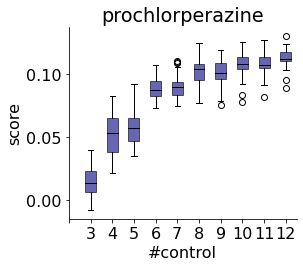

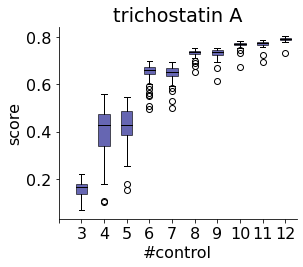

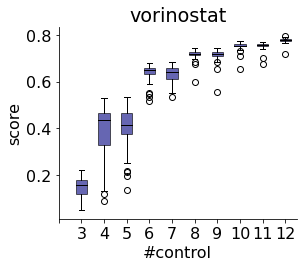

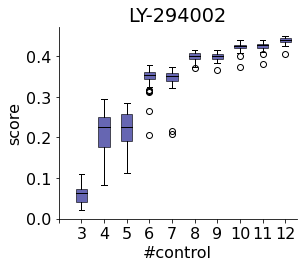

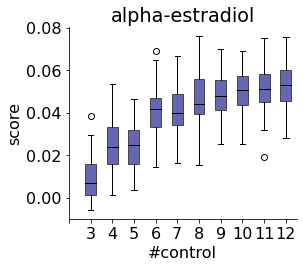

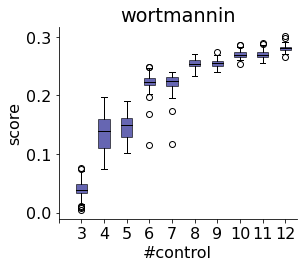

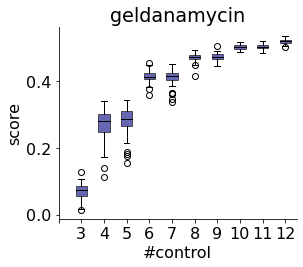

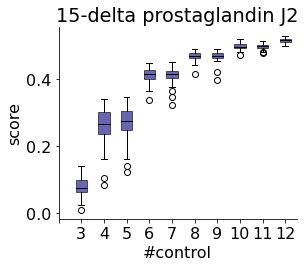

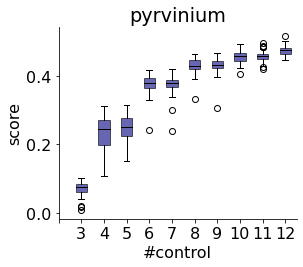

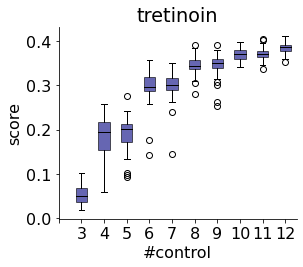

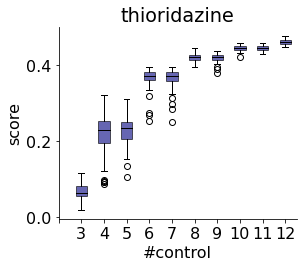

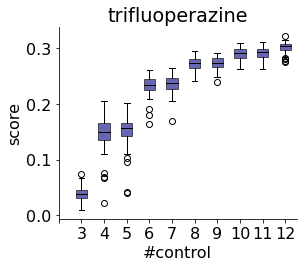

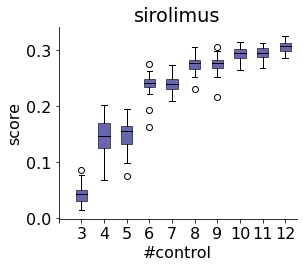

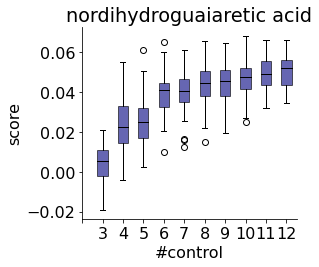

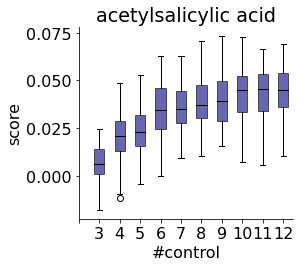

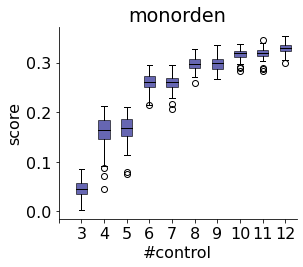

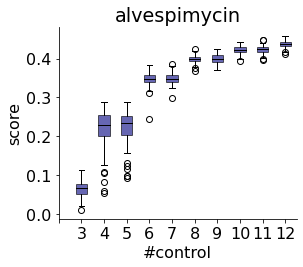

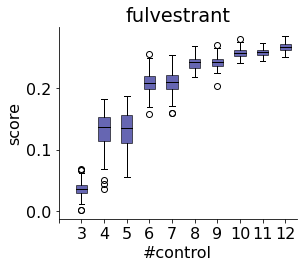

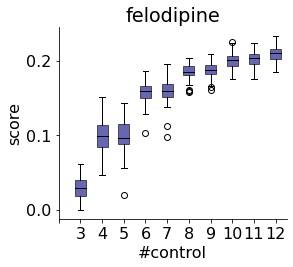

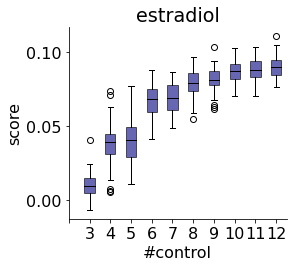

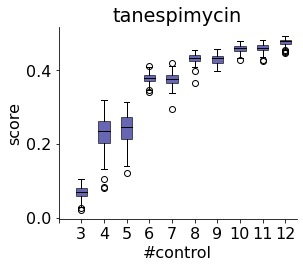

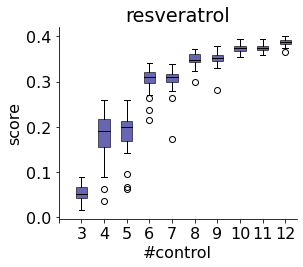

In [9]:
# prepare boxplots for each compound
plot_each()

In [28]:
# check treatment replicates
check_rep()